The following are plots generated from all available Booking.com data.

A few noteworthy points:
1. Carmel is "Carmel-by-the-Sea"
2. This data is still in Euro's, let's keep it this way til we can retroactively convert to USD all at once
3. The plots are in order: Number of Bookings, Revenue, and Room Nights


You can immediately see some interesting trends. 

This is a good deal for Carmel-by-the-Sea and Monterey bookings are on the decline. More to come...


Up Next:

1. Bake in Google Analytics data for further analysis including impressions, CTR, etc
2. Check on 'Canceled Bookings' / Zero fee listings, Ask Allyson
3. Formalize a report on Bookings.com, potentially incorporate this into the onsite-ad-analysis report
4. More





In [334]:
%%html
<style>
div.input {
    display:none;
}
</style>

In [335]:
%matplotlib inline

In [336]:
import warnings
import os
import pandas as pd
import numpy as np
from ggplot import *

warnings.filterwarnings('ignore')


##############################################################
# Some constants and data I am going to need later on in the analysis

jurisdictions = ['Carmel Valley',
                 'Carmel',
                 'Monterey',
                 'Pacific Grove',
                 'Salinas',
                 'Seaside',
                 'Marina']

##############################################################
# Let's pull in the bookingcom data, it has been pulled from the 
# web and formatted for a quick amalgamation

files = os.listdir('onsite_ad_analysis')
booking_files = [f for f in files if 'booking' in f]
booking_frames = []
for f in booking_files:
    directory = 'onsite_ad_analysis'
    path = os.path.join(directory, f) 
    temp = pd.read_csv(path)
    booking_frames.append(temp)

booking_data = pd.concat(booking_frames)

##############################################################
# Let's format the Booking data

#PLEASE NOTE: All bookingcom data is in Euro's unless otherwise noted. 
# will convert when we can convert retroactively and at once

#Rename Columns
booking_data = booking_data.rename(
        columns={
        "book nr." : "book_nr",
        "booked"  : "booked",
        "arrival" : "arrival",
        "departure" : "departure",
        "comission ( EUR )" : "commission_eur",
        "perc" : "fee_eur",
        "total transaction value ( EUR )" : "dollar_value", 
        "slip nr." : "slip_nr",
        "affiliate id" : "affiliate_id",
        "hotel name" : "hotel_name",
        "accomodation type" : "accomodation_type",
        "hotel city" : "hotel_city",
        "hotel ufi" : "hotel_ufi"
    })

#Subset Columns needed
booking_data_v2 = booking_data[['booked',
                                'arrival',
                                'departure',
                                'commission_eur',
                                'dollar_value',
                                'hotel_name',
                                'hotel_city',
                                'accomodation_type']]


booking_data_v2['booked'] = pd.to_datetime(booking_data_v2['booked'])
booking_data_v2['arrival'] = pd.to_datetime(booking_data_v2['arrival'])
booking_data_v2['departure'] = pd.to_datetime(booking_data_v2['departure'])

booking_data_v2['Room-Nights'] = booking_data_v2['departure'] - booking_data_v2['arrival']
booking_data_v2['Room-Nights'] = booking_data_v2['Room-Nights']/np.timedelta64(1, 'D')


booking_data_v2['Month-Year'] = booking_data_v2['booked'].apply(lambda x: str(x.month) + "-" + str(x.year))
booking_data_v2 = booking_data_v2.sort(['booked'], ascending = False)

##############################################################
# Let's subset


# Time Subsetting
mask = (booking_data_v2['booked'] > '2015-05-01') & (booking_data_v2['booked'] < '2015-09-30')
bd = booking_data_v2.loc[mask]

# Comment this out to activate Time Subsetting
bd_v2 = booking_data_v2

# Subset to get rid of cancels/no pays?
#bd_v2 = bd[bd['commission_eur'] > 0.00]

#Monterey County is composed of: Big Sur, Carmel Valley, Moss Landing, King City
bd_v2 = bd_v2[bd_v2['hotel_city'].isin(jurisdictions)]


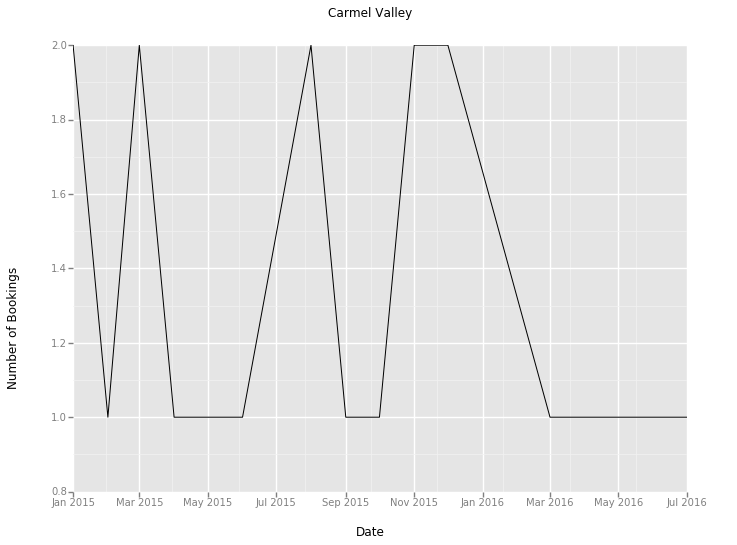

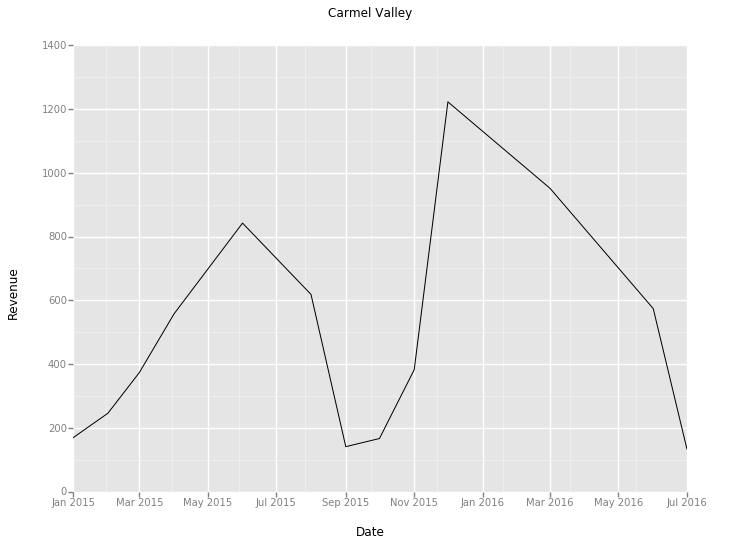

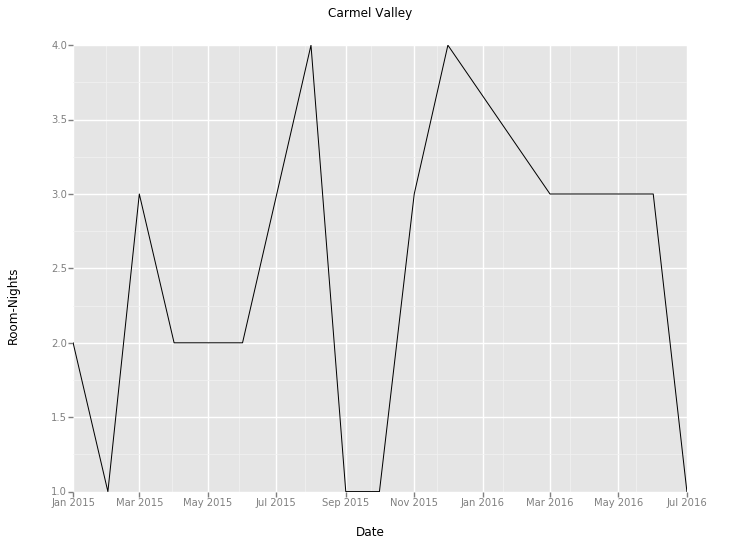

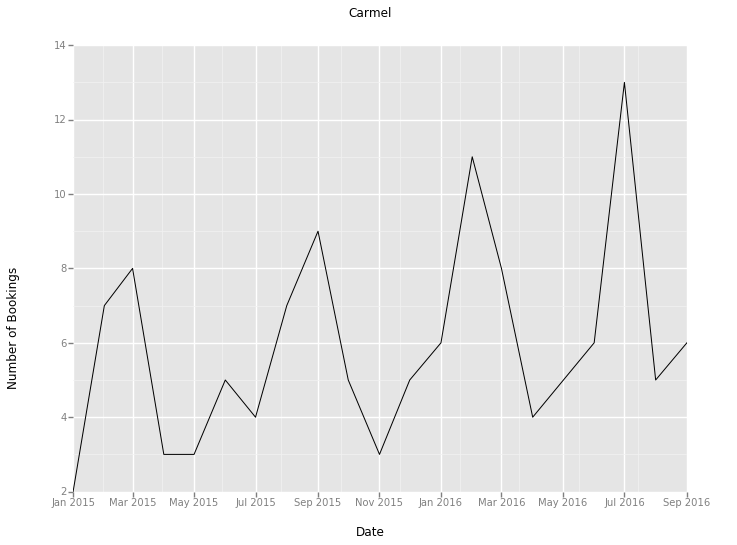

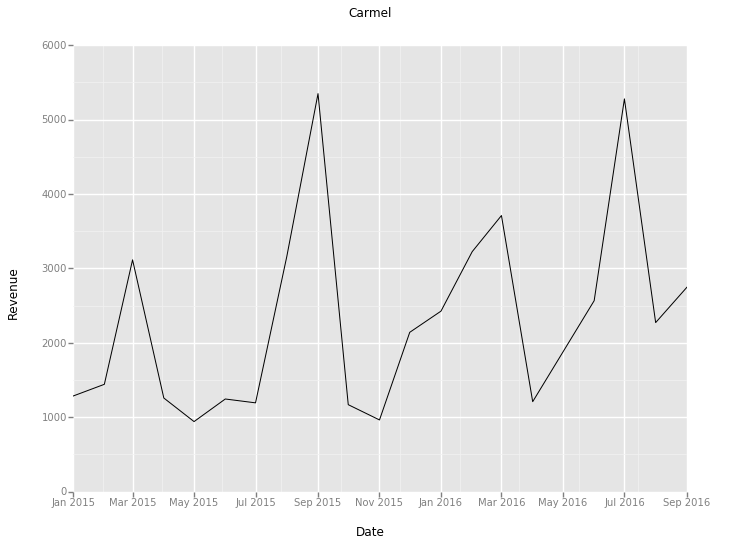

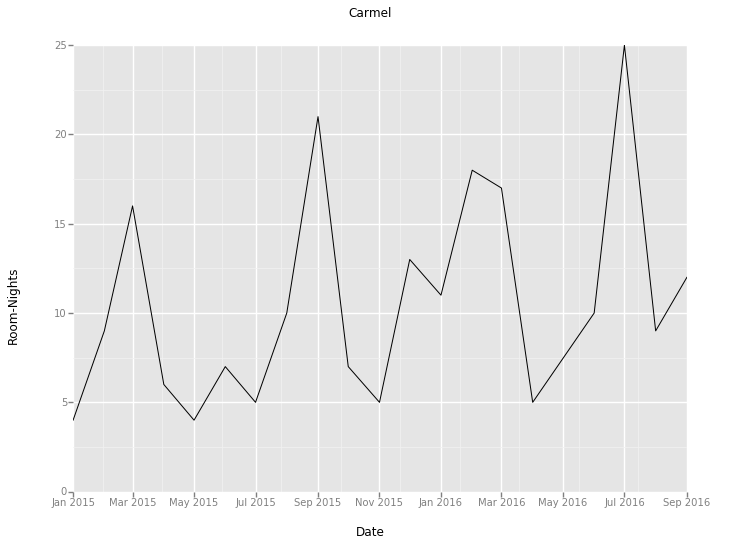

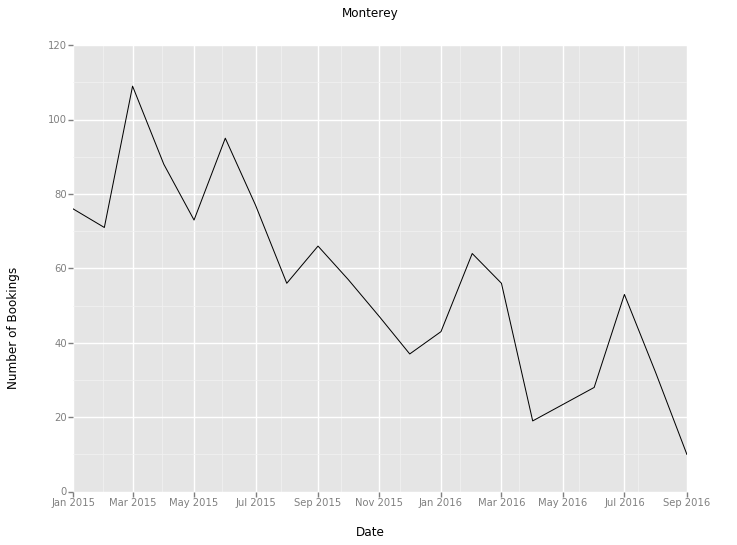

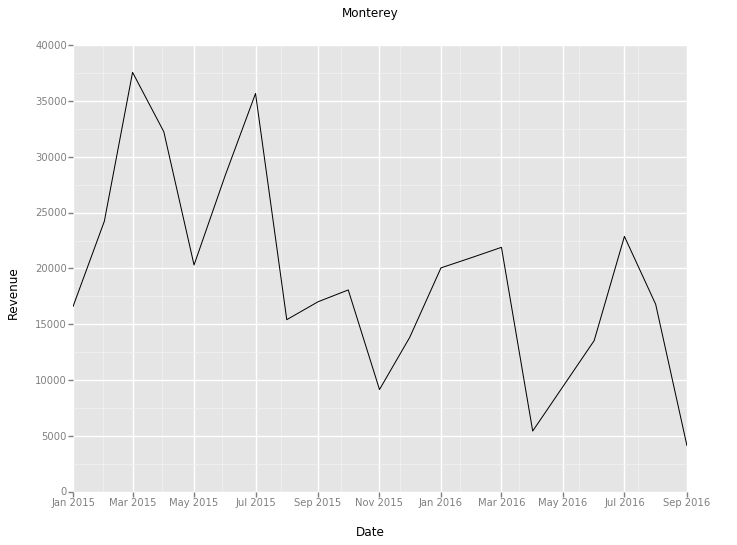

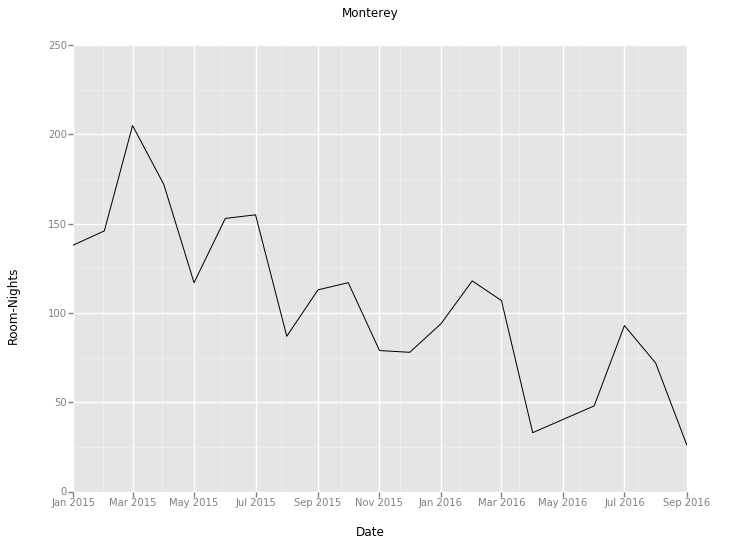

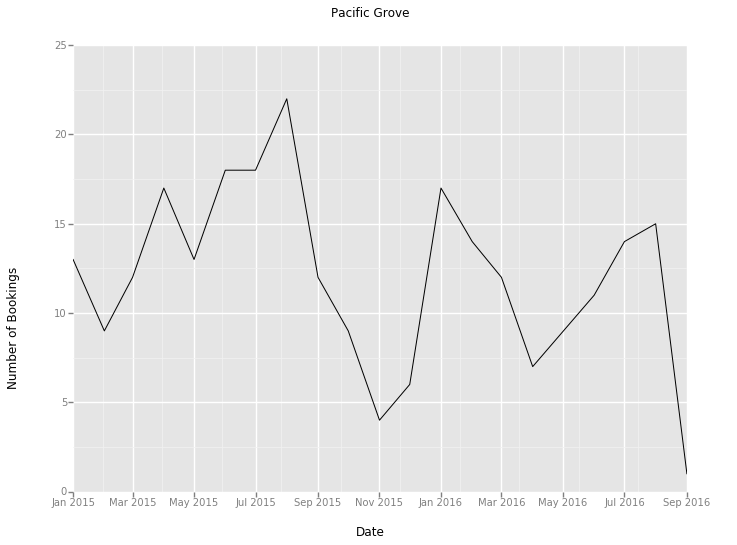

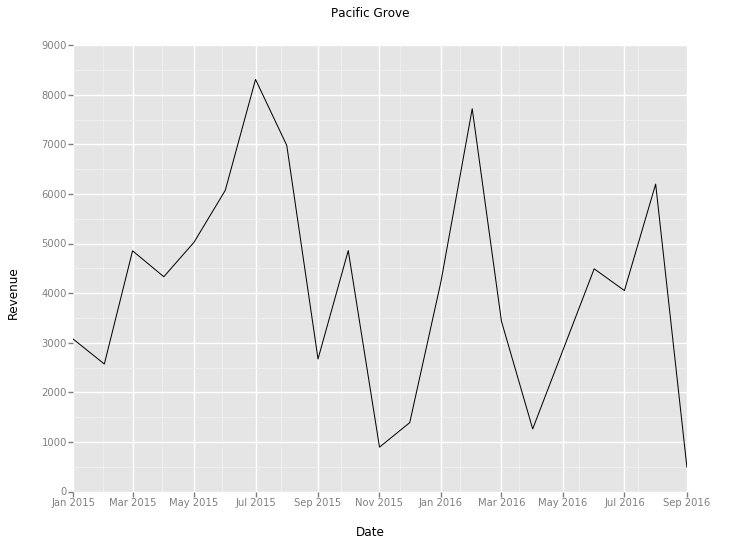

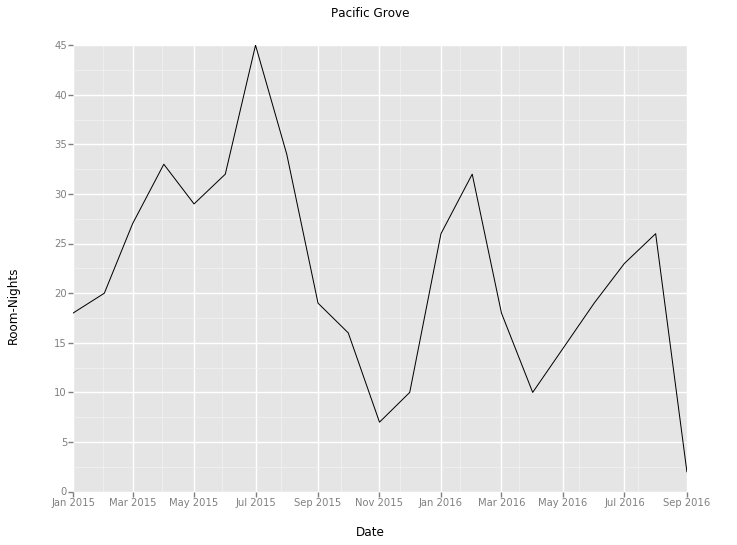

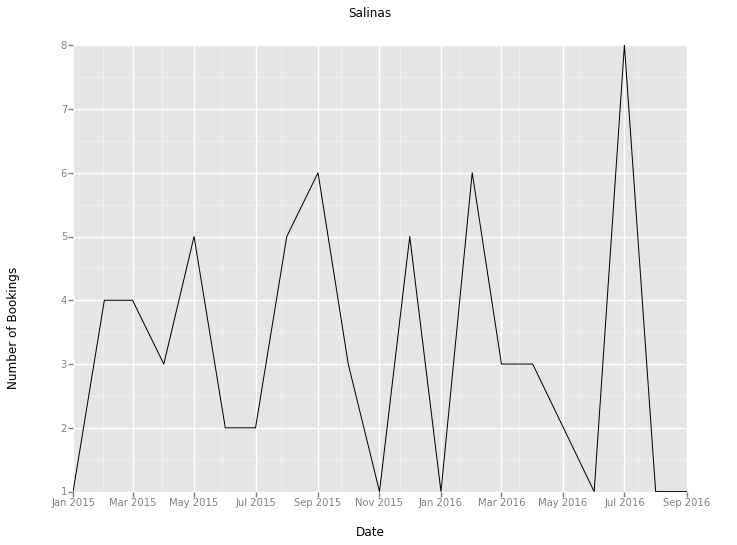

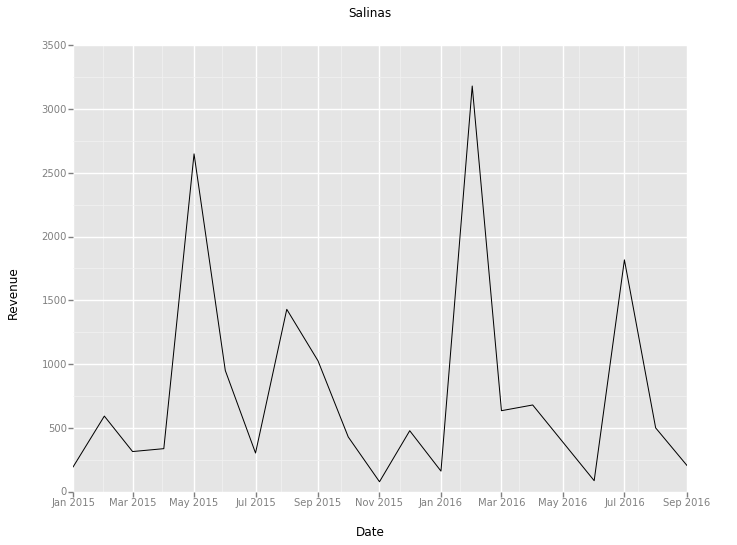

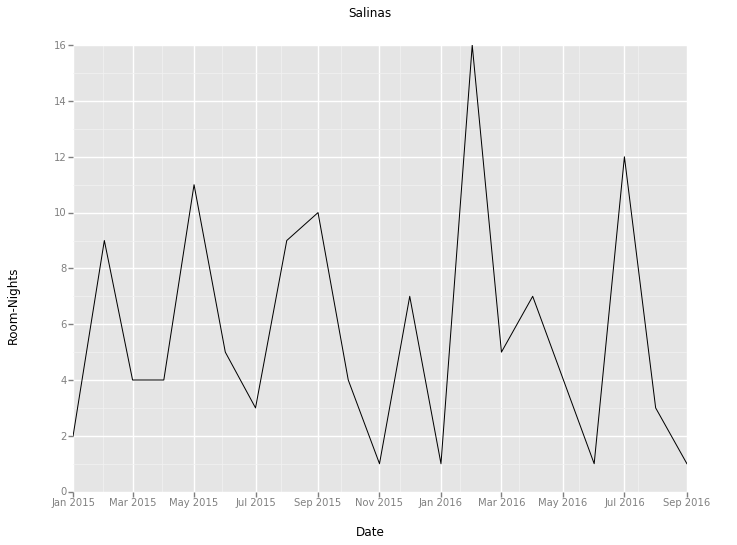

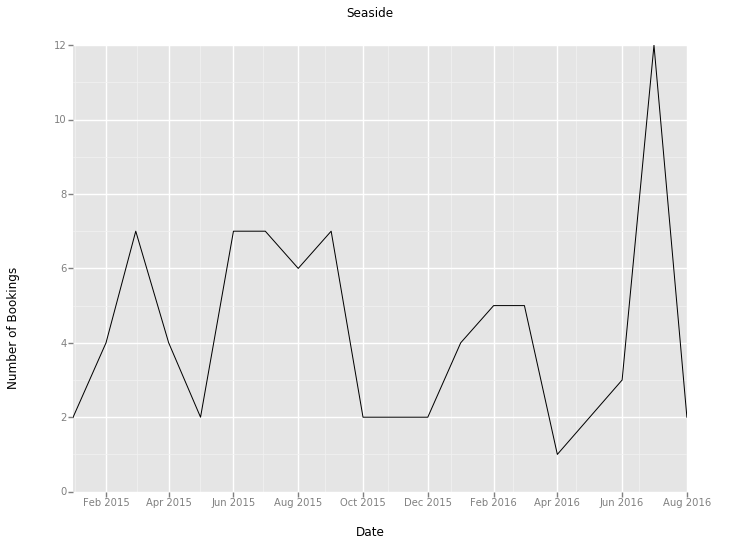

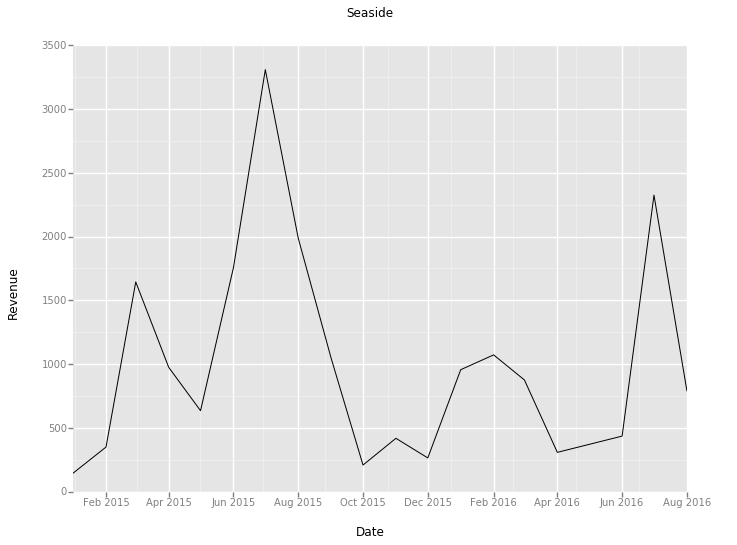

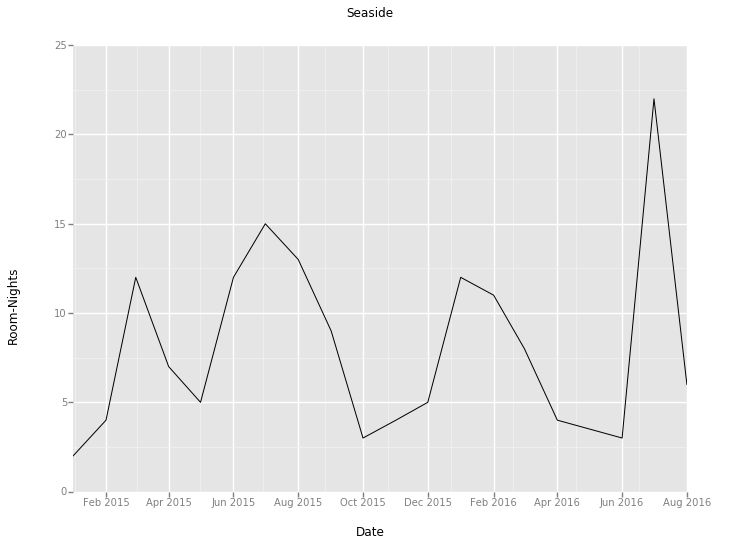

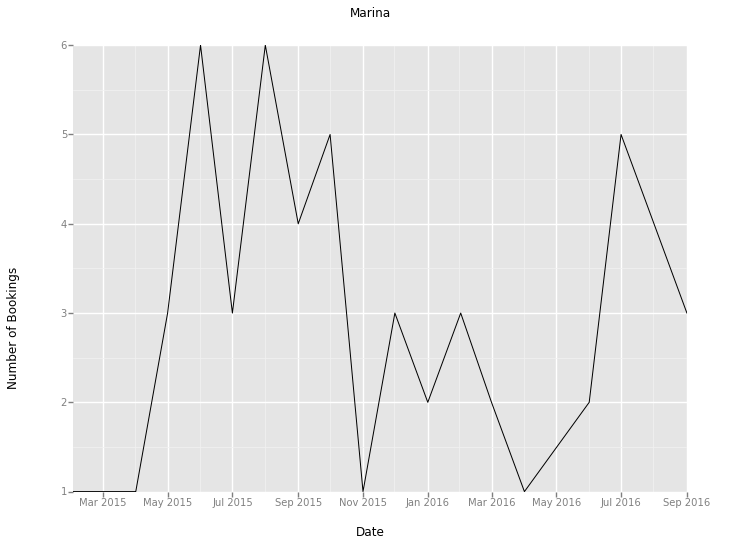

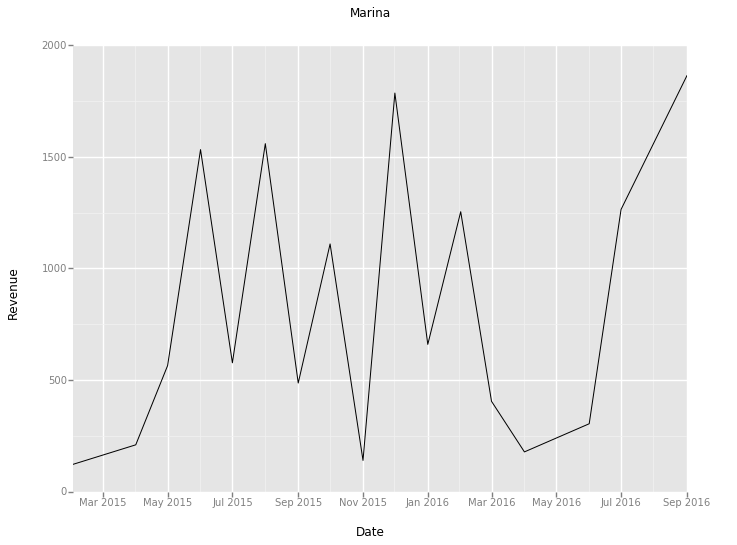

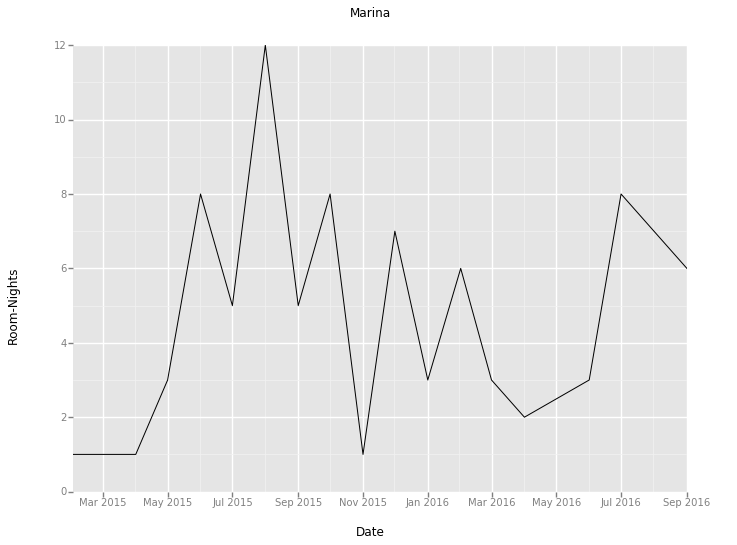

In [337]:
##############################################################
# Let's format the Booking data further into visualiztions


bd_grp = bd_v2.groupby(['hotel_city','Month-Year'])
bd_grp_rev_cities   = bd_grp['dollar_value'].aggregate(sum) # Sum of revenue by cities
bgrc = bd_grp_rev_cities.reset_index()
bgrc['Date'] = pd.to_datetime(bgrc['Month-Year'], format = "%m-%Y")
bgrc = bgrc.sort(['Date'], ascending = True)
bgrc['Month-Year'] = bgrc['Month-Year'].apply(str)


bd_grp_count_cities = bd_grp.aggregate(len) # Count of cities
bgcc = bd_grp_count_cities.reset_index()
bgcc['Date'] = pd.to_datetime(bgcc['Month-Year'], format = "%m-%Y")
bgcc = bgcc.sort(['Date'], ascending = True)


bd_grp_RN = bd_grp['Room-Nights'].aggregate(sum) #Sum of Room Nights
bgrn = bd_grp_RN.reset_index()
bgrn['Date'] = pd.to_datetime(bgrn['Month-Year'], format = "%m-%Y")
bgrn = bgrn.sort(['Date'], ascending = True)


############################################################
# Let's do some basic Visualizations

bp = ggplot(aes(x='Date',y='dollar_value', color = 'hotel_city'), data = bgrc) 
bp = bp + geom_line()

bgrc_carmel = bgrc[bgrc['hotel_city'] == 'Carmel']
bp_carmel = ggplot(aes(x='Date',y='dollar_value'), data = bgrc_carmel) + geom_line()
bp_carmel




viz_rn_list = []
viz_count_list = []
viz_rev_list = []
for juris in jurisdictions:
    
    temp_bgcc = bgcc[bgcc['hotel_city'] == juris]
    temp_bp   = ggplot(aes(x='Date',y='dollar_value'), data = temp_bgcc) + geom_line() 
    temp_bp   = temp_bp + ylab("Number of Bookings") + xlab("Date") + ggtitle(juris)
    temp_bp.show()
    viz_count_list.append(temp_bp)
    
    temp_bgrc = bgrc[bgrc['hotel_city'] == juris]
    temp_bp   = ggplot(aes(x='Date',y='dollar_value'), data = temp_bgrc) + geom_line() 
    temp_bp   = temp_bp + ylab("Revenue") + xlab("Date") + ggtitle(juris)
    temp_bp.show()
    viz_rev_list.append(temp_bp)
    
    
    temp_bgrn = bgrn[bgrn['hotel_city'] == juris]
    temp_bp   = ggplot(aes(x='Date',y='Room-Nights'), data = temp_bgrn) + geom_line()
    temp_bp   = temp_bp + ylab("Room-Nights") + xlab("Date") + ggtitle(juris)
    temp_bp.show()
    viz_rn_list.append(temp_bgrn)


